# Seasonal ARIMA model for forecasting future production of a beer company.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('monthly-beer-production-in-austr.csv')

In [3]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [4]:
df.tail()

,Month,Monthly beer production
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0
475,1995-08,153.0


## EDA and Data Wraggling Process

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [6]:
## Changing the heading of columns
df.columns=["Month","Production"]
df.head()

,Month,Production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [7]:
# Convert Month into Datetime
df['Month']=pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)

In [8]:
df.head()

,Production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [9]:
df.tail()

,Production
Month,
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0
1995-07-01,119.0
1995-08-01,153.0


In [10]:
df.describe()

,Production
count,476.000000
mean,136.395378
std,33.738725
min,64.800000
25%,112.900000
50%,139.150000
75%,158.825000
max,217.800000


## Data Visualization

<Axes: xlabel='Month'>

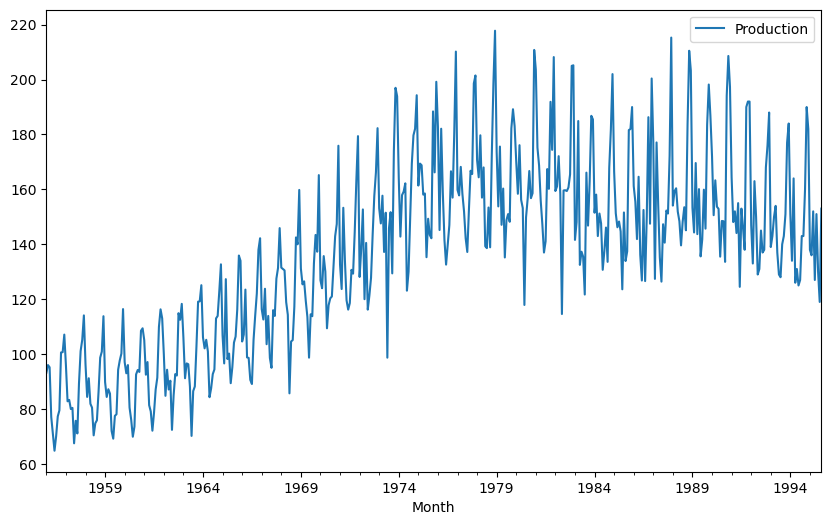

In [11]:
df.plot (figsize=(10, 6), legend=True)

Distinguishable patterns emerge when plotting the data. The time-series exhibits a clear seasonality pattern, with consistently low productions at the beginning of the year and a peak towards the end. Additionally, there is a visible upward trend within each calendar year, accompanied by a few months of lower sales in the mid-year.

To enhance our understanding, we can employ a method known as time-series decomposition. This method enables us to break down our time series into three distinct components: trend, seasonality, and noise.

In [12]:
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

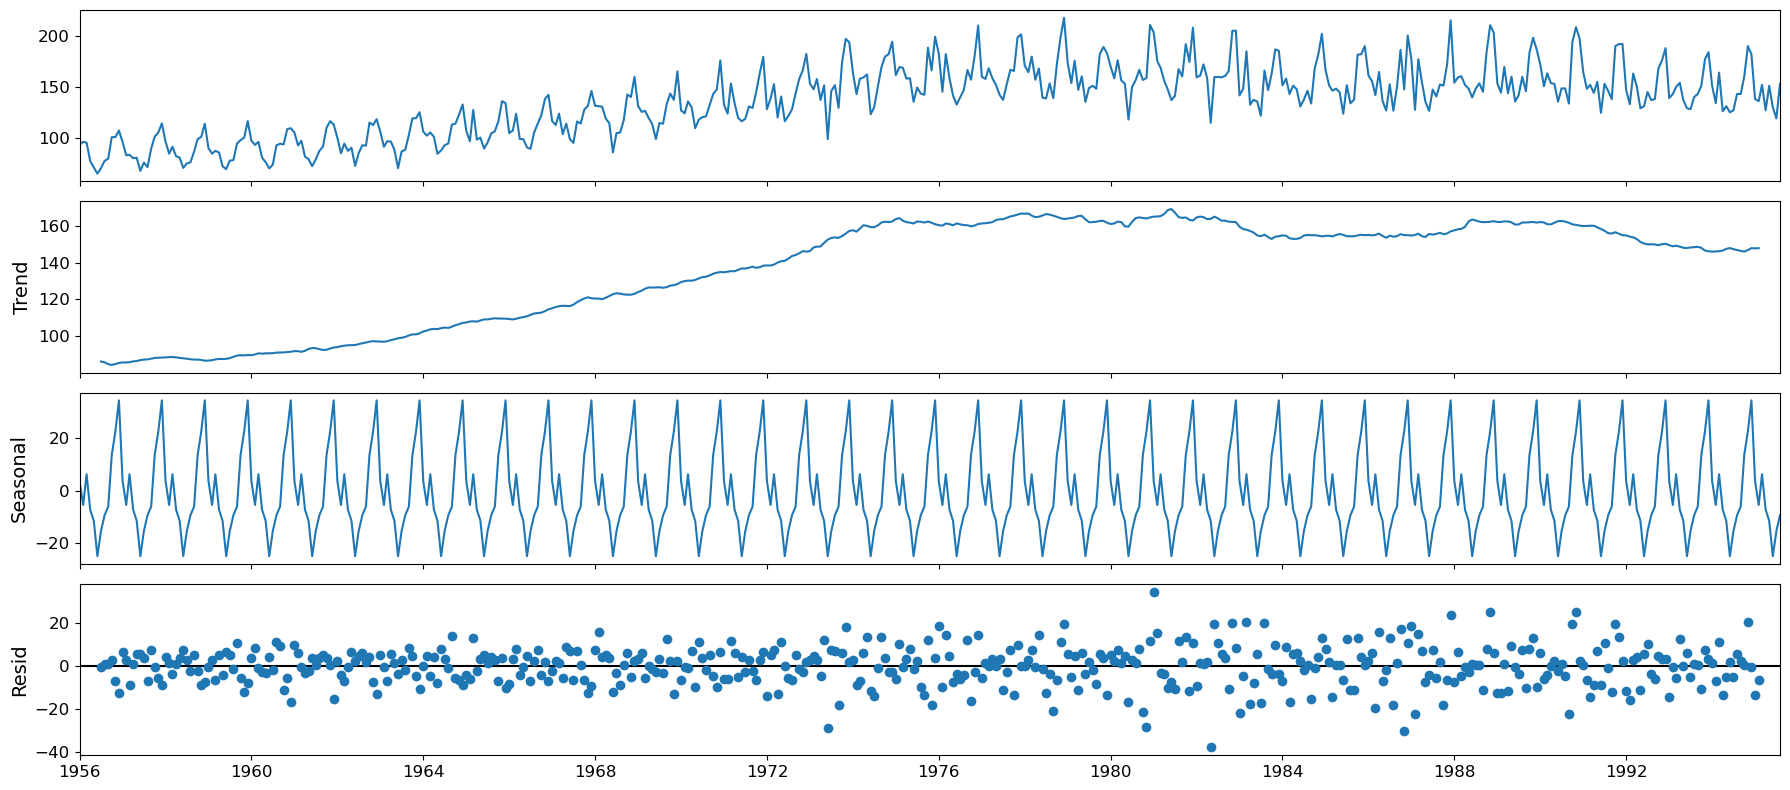

In [13]:
# Decomposition Plots
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the production of beer is initially increasing and then becoming almost stable, along with its obvious seasonality.

## Statistical evaluation to find the stationarity of the data (through ADFuller test).

In [14]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [15]:
test_result=adfuller(df['Production'])

In [16]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(production):
    result=adfuller(production)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [17]:
adfuller_test(df['Production'])

ADF Test Statistic : -2.2826614187875833
p-value : 0.17762099829132294
#Lags Used : 17
Number of Observations Used : 458
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


From the ADFuller test it is clear that the data is non-stationary, but to apply ARIMA or Seasonal ARIMA model we need to first make the data stationary.

In order to make the data stationary, we can apply differencing method.

## Differencing

In [18]:
## Since the data shows seasonality pattern, so we can take the shift of 12 months.
df_copy = df.copy()
df_copy['Seasonal First Difference'] = df['Production'] - df['Production'].shift(12)
df_copy.head(14)

,Production,Seasonal First Difference
Month,,
1956-01-01,93.2,NaN
1956-02-01,96.0,NaN
1956-03-01,95.2,NaN
1956-04-01,77.1,NaN
1956-05-01,70.9,NaN
1956-06-01,64.8,NaN
1956-07-01,70.1,NaN
1956-08-01,77.3,NaN
1956-09-01,79.5,NaN


In [19]:
## Again test dickey fuller test
adfuller_test(df_copy['Seasonal First Difference'].dropna())

ADF Test Statistic : -2.8967624777520053
p-value : 0.045725774623596706
#Lags Used : 17
Number of Observations Used : 446
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Month'>

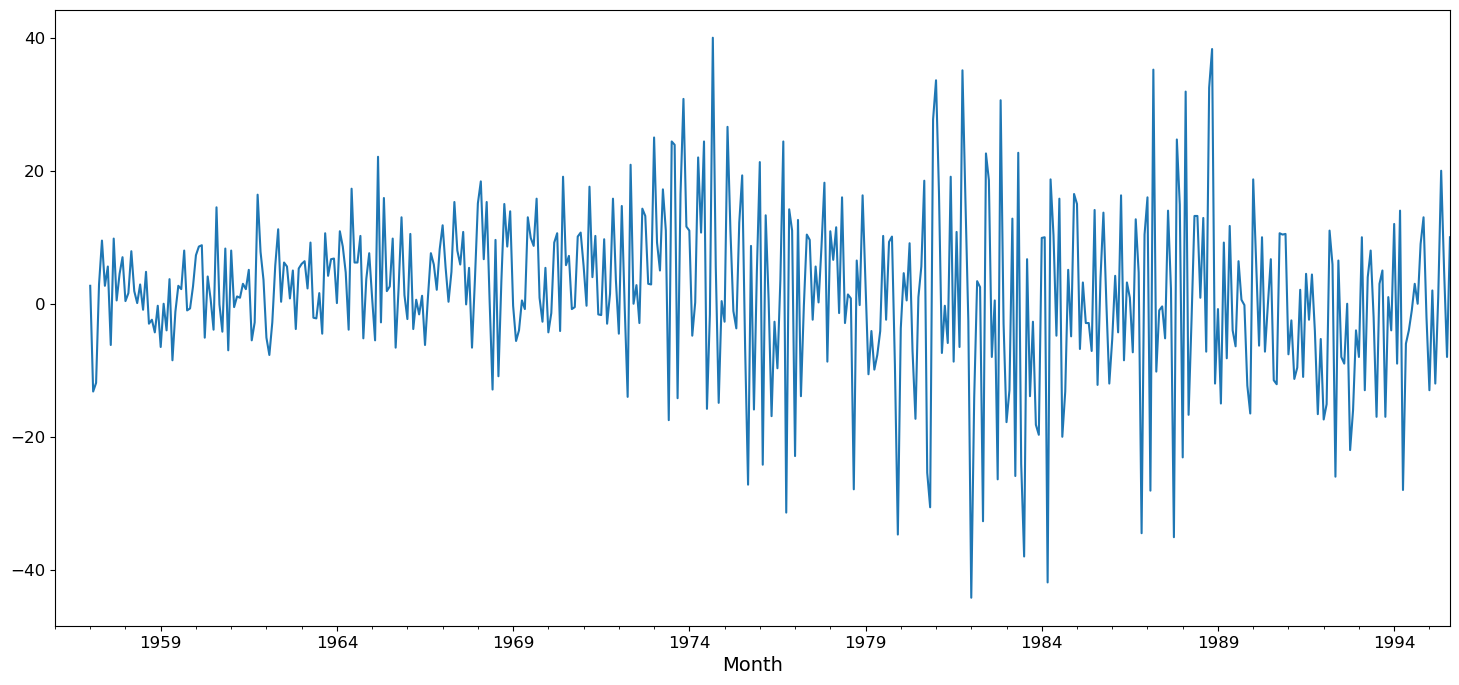

In [20]:
df_copy['Seasonal First Difference'].plot()

From the above fig it is clear that the mean and variance of the above plot are constant, which are the basic condition of making the dataset to be staionary. 

##  Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plot.

The most effective method for identifying an AR model is often through the use of the PACF.

In the case of an AR model, the theoretical PACF demonstrates a clear termination beyond the model's order. The term "shuts off" signifies that, in theory, partial autocorrelations become zero beyond this point. In simpler terms, the count of non-zero partial autocorrelations indicates the order of the AR model.

Conversely, when identifying an MA model, it is typically more effective to utilize the ACF rather than the PACF.

In an MA model, the theoretical PACF does not exhibit a complete shutdown but rather tapers towards 0 in a certain manner. The ACF provides a clearer pattern for an MA model, with non-zero autocorrelations appearing solely at lags involved in the model.

The notation p, d, q signifies the order of the ARIMA model, where p represents AR model lags, d denotes differencing, and q signifies MA model lags.

In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

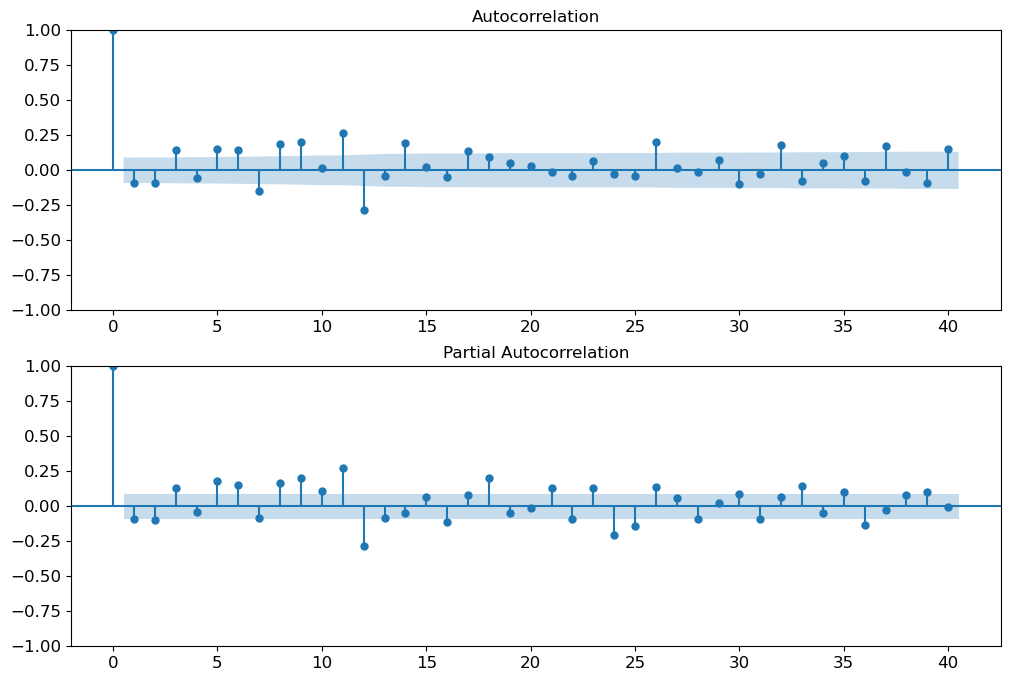

In [22]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_copy['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_copy['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

### 1) ARIMA Model

To work with ARIMA model we need to find the (p,d,q) value either manually using PACF and ACF plot or by using auto-ARIMA. In this case we try to manually predict the (p,d,q) value.

The general thumb rule for finding the p and q value using PACF and ACF plot is to check the first point where it touches outskirts of blue portion will gives us the required value.

For p value, we will look at PACF plot. Here, we can see p = 1 .
Similarly, for q value we will look at ACF plot. Here, we can see q = 1 .
And we have taken lag or differencing only once, so d = 1.

In [23]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Update this based on your actual data and column names

# Make sure your 'Production' column is in a numeric format
df['Production'] = pd.to_numeric(df['Production'], errors='coerce').fillna(0)

# Create the ARIMA model
model = ARIMA(df['Production'], order=(1, 1, 1))

# Fit the model
model_fit = model.fit()

D:\Users\bidis\Desktop\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Users\bidis\Desktop\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Users\bidis\Desktop\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Validating forecasts

Here, we have used visualization method to check how valid our prediction is.

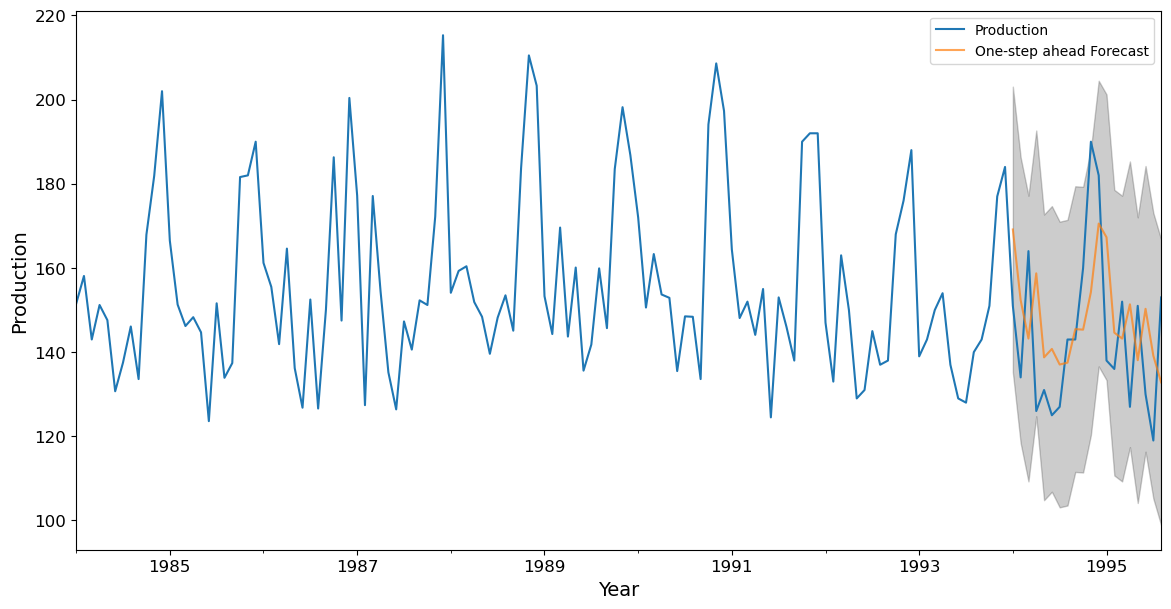

In [24]:
pred = model_fit.get_prediction(start=pd.to_datetime('1994-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['1984':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Year')
ax.set_ylabel('Production')
plt.legend()
plt.show()

In [25]:
df_forecasted = pred.predicted_mean
df_truth = df['1994-01-01':]
df_truth['pred'] = df_forecasted
df_truth

C:\Users\bidisha\AppData\Local\Temp\ipykernel_4792\3555247224.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_truth['pred'] = df_forecasted


,Production,pred
Month,,
1994-01-01,151.0,169.146930
1994-02-01,134.0,152.345644
1994-03-01,164.0,143.223139
1994-04-01,126.0,158.719311
1994-05-01,131.0,138.758322
1994-06-01,125.0,140.758215
1994-07-01,127.0,137.056352
1994-08-01,143.0,137.495183
1994-09-01,143.0,145.470193


### Statistical method to calculate validation of forecast for ARIMA Model.

In [26]:
# By using Mean Squred Error (MSE) method

mse = ((df_truth['Production'] - df_truth['pred']) ** 2).mean()

# Print the MSE
print('The Mean Squared Error of our forecasts for ARIMA Model is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts for ARIMA Model is 361.6


In [27]:
# By using Root Mean Squred Error (rmse) method

rmse = np.sqrt(mse)
print('The Root-Mean Squared Error of our forecasts for ARIMA Model is {}'.format(round(rmse, 2)))

The Root-Mean Squared Error of our forecasts for ARIMA Model is 19.02


## 2) Seasonal ARIMA (SARIMA) Model

In [28]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Using a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [29]:
# Set the frequency explicitly (e.g., 'MS' for Month Start)
df.index.freq = 'MS'

# Assuming you have defined pdq and seasonal_pdq before this loop
# Adjust the loop according to your actual data and parameters

column_to_use = 'Production'

# Initialize variables to track the lowest AIC and corresponding model parameters
lowest_aic = np.inf
best_params = None

# Loop through parameter combinations
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df[column_to_use],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            # Print AIC for the current parameter combination
            print(f'ARIMA{param}x{param_seasonal}12 - AIC:{results.aic}')
            
            # Check if the current AIC is the lowest
            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_params = (param, param_seasonal)
                
        except Exception as e:
            print(f"Error for {param}x{param_seasonal}: {str(e)}")
            continue

# Print the lowest AIC and corresponding parameters
print(f'\nLowest AIC: {lowest_aic} for parameters {best_params}')

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:6048.483263315012
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:5353.324473760271
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3656.940289295834
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3533.40295458228
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3663.9278237263366
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3613.3364115908716
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3545.1636287409438
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3535.3960111654487
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:5461.584624684903
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:4916.811619563323
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3648.0809791518905
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3528.3229566211685
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3662.0264135843263


D:\Users\bidis\Desktop\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3608.645969389103
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3547.067825819041
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3530.3129837883234
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:4170.542605855215
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3966.060096945921
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:4002.1497128324327
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:3707.628994267343
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:3905.725107345436
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:3800.847430134346
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:3851.67630763785
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:3709.340098038204
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:4129.179521190977
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3833.0693652212503
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:3630.4994492037877
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:3380.330041186583
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:3607.198640238382
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:3469.995415911998
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:3501.830521315706
ARIMA(0

### Model fitting

In [30]:
# Set the frequency explicitly (e.g., 'MS' for Month Start)
df.index.freq = 'MS'

# Select the column to use as the univariate time series
column_to_use = 'Production'

# Define SARIMAX model
mod = sm.tsa.statespace.SARIMAX(df[column_to_use],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit the model
results = mod.fit()

### Validation of SARIMA Model

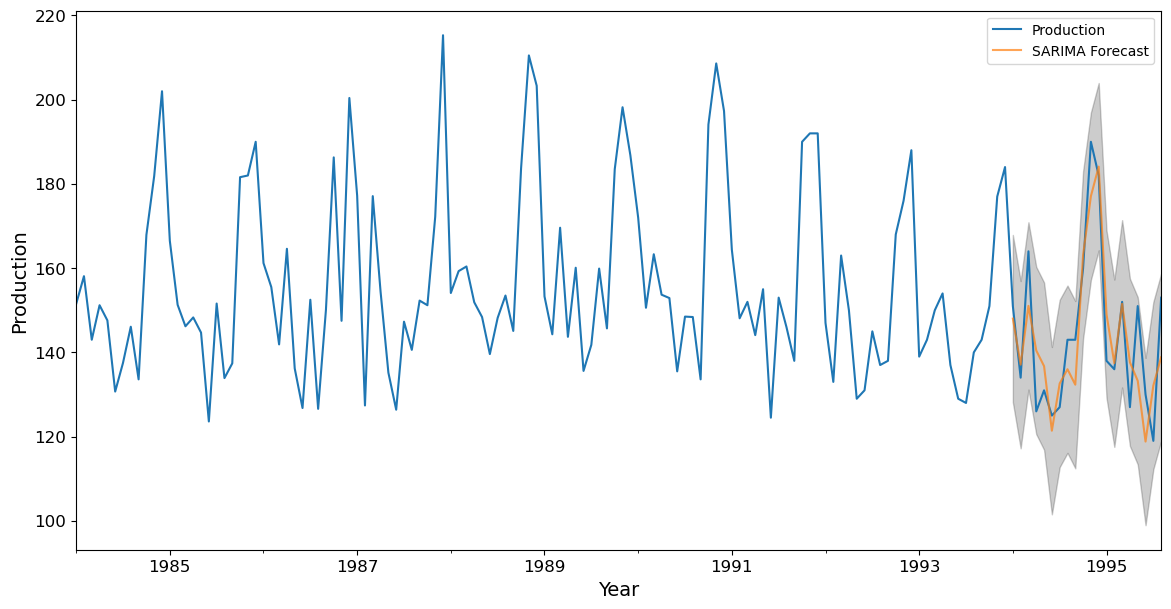

In [31]:
# By Visualizing the data
# Get one-step ahead forecast for SARIMA model
pred1 = results.get_prediction(start=pd.to_datetime('1994-01-01'), dynamic=False)
pred1_ci = pred1.conf_int()

# Plot the observed values and forecast, starting from 1984
ax = df['1984':].plot(label='observed', figsize=(14, 7))
pred1.predicted_mean.plot(ax=ax, label='SARIMA Forecast', alpha=.7)

# Highlight the validation period
ax.fill_between(pred1_ci.index,
                pred1_ci.iloc[:, 0],
                pred1_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Year')
ax.set_ylabel('Production')
plt.legend()
plt.show()

In [32]:
df_forecasted = pred1.predicted_mean
df_truth = df['1994-01-01':]
df_truth['pred1'] = df_forecasted
df_truth

C:\Users\bidisha\AppData\Local\Temp\ipykernel_4792\981518851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_truth['pred1'] = df_forecasted


,Production,pred1
Month,,
1994-01-01,151.0,148.025394
1994-02-01,134.0,137.085699
1994-03-01,164.0,151.043376
1994-04-01,126.0,140.453554
1994-05-01,131.0,136.737685
1994-06-01,125.0,121.416577
1994-07-01,127.0,132.620493
1994-08-01,143.0,136.009121
1994-09-01,143.0,132.336607


### Statistical method to calculate validation of forecast for SARIMA Model.

In [33]:
# By using Mean Squred Error (MSE) method

mse = ((df_truth['Production'] - df_truth['pred1']) ** 2).mean()

# Print the MSE
print('The Mean Squared Error of our forecasts for SARIMA Model is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts for SARIMA Model is 93.26


In [34]:
# By using Root Mean Squred Error (rmse) method

rmse = np.sqrt(mse)
print('The Root-Mean Squared Error of our forecasts for SARIMA Model is {}'.format(round(rmse, 2)))

The Root-Mean Squared Error of our forecasts for SARIMA Model is 9.66


From the above two model it is clear that SARIMA model gives the least error value and is best fit for forecasting future production of beer. Thus, we will use SARIMA Model.

## Forecasting Future Production using SARIMA model

In [35]:
# Precting future production for next 3 years or for next 36 months
pred1_fc = results.get_forecast(steps=36)
fut_df = pd.DataFrame(pred1_fc.predicted_mean)
fut_df.columns = ['Future_pred']
fut_df

,Future_pred
1995-09-01,133.636658
1995-10-01,164.497897
1995-11-01,178.979508
1995-12-01,184.942683
1996-01-01,146.182506
1996-02-01,136.326790
1996-03-01,152.269569
1996-04-01,136.506879
1996-05-01,136.244934
1996-06-01,123.221736


### Visualizing  Predicted value

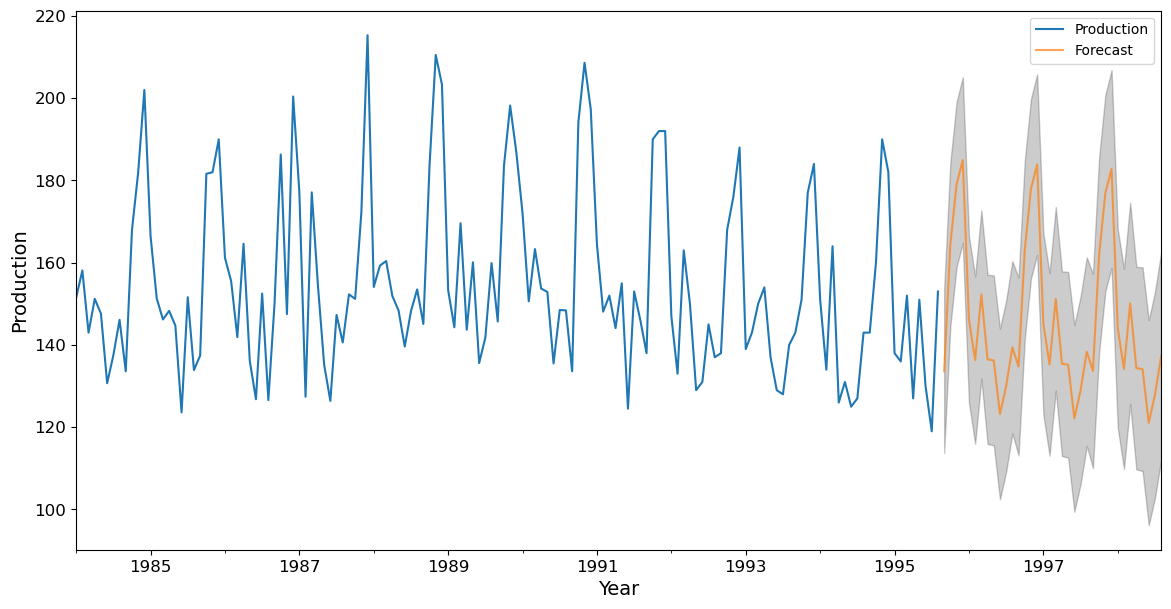

In [36]:
# Get forecast for the next 36 steps (adjust as needed)
pred1_fc = results.get_forecast(steps=36)
pred1_ci = pred1_fc.conf_int()

# Plot the observed values, forecast, and confidence intervals
ax = df['1984':].plot(label='observed', figsize=(14, 7))
pred1_fc.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

# Highlight the validation period
ax.fill_between(pred1_ci.index,
                pred1_ci.iloc[:, 0],
                pred1_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Year')
ax.set_ylabel('Production')
plt.legend()
plt.show()